In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import optim
from tqdm import tqdm
import sklearn

In [23]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object') or True):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df


def preprocessing(df):
    # df["label"][df["label"]=="benign"] = 0
    # df["label"][df["label"]=="outlier"] = 1
    # df["label"][df["label"]=="malicious"] = 2
    # df["label"] = df["label"].astype(np.int16)

    df["dest_port"] = df["dest_port"] / df["dest_port"].max()
    df["src_port"] = df["src_port"] / df["src_port"].max()
    df["dest_port"][df["dest_port"].isna()] = -1
    df["src_port"][df["src_port"].isna()] = -1


class ThreatDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.features = self.df.drop(columns = ['label']).values
        df_enc = oneHotEncode(self.df, ["label"])
        self.label = df_enc[["label_benign", "label_malicious", "label_outlier"]].to_numpy()
        # self.label = self.df.label.values
        
    def __len__(self):
        return (len(self.df))
    
    def __getitem__(self, idx):
        return (torch.tensor(self.features[idx], dtype=torch.float), torch.tensor(self.label[idx], dtype=torch.float))

In [2]:
path = "Dataset/2020/06/2020.06.19/2020.06.19.csv"
df = pd.read_csv(path)
preprocessing(df)
df

,avg_ipt,bytes_in,bytes_out,dest_ip,dest_port,entropy,num_pkts_out,num_pkts_in,proto,src_ip,src_port,time_end,time_start,total_entropy,label,duration
0,7.500000,342,3679,786,9200.0,5.436687,2,2,6,786,57392.0,1592533725648144,1592533725632946,21860.918000,benign,0.015198
1,0.000000,0,0,786,55972.0,0.000000,1,1,6,49453,49493.0,1592533744644904,1592533744644904,0.000000,outlier,0.000000
2,0.500000,15440,942,786,9300.0,2.203135,3,3,6,786,60512.0,1592533770936279,1592533770933553,36091.754000,benign,0.002726
3,20.217391,622,31010,786,9300.0,1.189945,23,5,6,786,60490.0,159253376770238,15925337672353,37640.355000,benign,0.467080
4,0.000000,0,0,786,59498.0,0.000000,1,1,6,786,9300.0,1592533772973114,1592533772973087,0.000000,benign,0.000027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765355,118.000000,270,191,786,445.0,4.570315,6,6,6,38592,50822.0,1592611182688869,1592611181766454,2106.915300,outlier,0.922415
765356,6.000000,340,611,786,9200.0,6.196277,2,2,6,786,51148.0,159261118308182,1592611183069313,5892.659700,benign,0.012507
765357,1.111111,348,9126,786,9200.0,2.999871,9,3,6,786,51146.0,1592611183081913,1592611183070674,28420.775000,benign,0.011239
765358,1602.500000,112,112,786,NaN,1.060336,2,2,1,16509,NaN,1592611179165795,159261117275518,237.515150,malicious,6.410615


In [29]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns="label"), df["label"], test_size=0.3, random_state=2)

# Baseline

### Using Gradient Boosting Classifier

In [26]:
gbc = GradientBoostingClassifier( random_state=2)   # 5min 48
gbc.fit(X_train, y_train)

GradientBoostingClassifier(random_state=2)

In [50]:
y_pred_gbc = gbc.predict(X_test)
print("accuracy_score: ", accuracy_score(y_pred_gbc, y_test))
print("f1_score: ", f1_score(y_pred_gbc, y_test, average=None))

accuracy_score:  0.9836895926971185
f1_score:  [0.99933627 0.97690361 0.94961798]


In [51]:
print("f1_score: ", f1_score(y_pred_gbc, y_test, average="weighted"))

f1_score:  0.9838433254634245


### Using Random Forest

In [47]:
rf = RandomForestClassifier(random_state=2)     # 1min 11
rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.2min finished


RandomForestClassifier(random_state=2, verbose=True)

In [52]:
y_pred_rf = rf.predict(X_test)
print("accuracy_score: ", accuracy_score(y_pred_rf, y_test))
print("f1_score: ", f1_score(y_pred_rf, y_test, average=None))
print("f1_score: ", f1_score(y_pred_rf, y_test, average="weighted"))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.0s finished


accuracy_score:  0.9984625971220515
f1_score:  [0.99981863 0.99788254 0.99556769]
f1_score:  0.998463765873796


# Feature Selection

### Kbest

In [53]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest

In [62]:
kbest_scores = {}
for i in range(1, X_train.columns.size):
    selector = SelectKBest(mutual_info_classif, k=i)
    selector.fit(X_train, y_train)

    X_train_5Best = selector.transform(X_train)
    X_test_5Best = selector.transform(X_test)

    gbc.fit(X_train_5Best, y_train)         # 5min 22
    y_pred_5best = gbc.predict(X_test_5Best)


    kbest_scores[i] = f1_score(y_test, y_pred_5best, average="weighted")

print("f1_score: ", kbest_scores)

f1_score:  {1: 0.9518514217611043}
f1_score:  {1: 0.9518514217611043, 2: 0.9757506152589774}
f1_score:  {1: 0.9518514217611043, 2: 0.9757506152589774, 3: 0.9802506621905414}
f1_score:  {1: 0.9518514217611043, 2: 0.9757506152589774, 3: 0.9802506621905414, 4: 0.9805085918129378}
f1_score:  {1: 0.9518514217611043, 2: 0.9757506152589774, 3: 0.9802506621905414, 4: 0.9805085918129378, 5: 0.9807785779536278}
f1_score:  {1: 0.9518514217611043, 2: 0.9757506152589774, 3: 0.9802506621905414, 4: 0.9805085918129378, 5: 0.9807785779536278, 6: 0.9822851547744932}
f1_score:  {1: 0.9518514217611043, 2: 0.9757506152589774, 3: 0.9802506621905414, 4: 0.9805085918129378, 5: 0.9807785779536278, 6: 0.9822851547744932, 7: 0.9808383219500043}
f1_score:  {1: 0.9518514217611043, 2: 0.9757506152589774, 3: 0.9802506621905414, 4: 0.9805085918129378, 5: 0.9807785779536278, 6: 0.9822851547744932, 7: 0.9808383219500043, 8: 0.9765559609201881}
f1_score:  {1: 0.9518514217611043, 2: 0.9757506152589774, 3: 0.9802506621905

f1_score:  {1: 0.9518514217611043, 2: 0.9757506152589774, 3: 0.9802506621905414, 4: 0.9805085918129378, 5: 0.9807785779536278, 6: 0.9822851547744932, 7: 0.9808383219500043, 8: 0.9765559609201881, 9: 0.9802876335898271, 10: 0.9814151655877491, 11: 0.9807568873519527, 12: 0.9782976520369402, 13: 0.9783289500591218, 14: 0.9804196577579725}


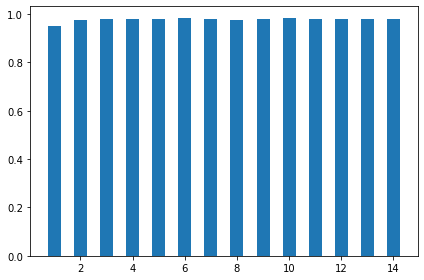

In [91]:
print("f1_score: ", kbest_scores)
import matplotlib.pyplot as plt
import numpy as np
plt.figure()
plt.bar(kbest_scores.keys(), kbest_scores.values(), width=0.5)
plt.tight_layout()